**VC-theory**

a) Чтобы точки можно было разделить, то они должны идти последовательно, сперва все минусы, а потом все минусы. Число способов поставить перегородку отделяющую плюс от минуса это $n + 1$. Зная функцию найти breakpoint уже не представляет труда. 

Итого:

m<sub>H</sub>(n) = n+1, breakpoint=2, d_<sub>VC</sub>=1

б) Теперь требуется поставить 2 перегородки, причем надо дополнительно учесть случай, когда 2 перегородки  стоят с одной стороны. Тогда:

m<sub>H</sub>(n) = n(n+1)/2+1, breakpoint=3, d_<sub>VC</sub>=2

In [257]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit

def read_dataset(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['label'].to_numpy()
    X = df.drop('label', axis=1).to_numpy()
    return X, y

X_blobs, y_blobs = read_dataset('blobs2.csv')

**Perception**

In [258]:
def calc_accuracy(X, w, y):
    incorrect_indices = []
    for i, x in enumerate(X):
        if np.dot(x, w) * y[i] < 0:
            incorrect_indices.append(i)
    return 1 - len(incorrect_indices) / X.shape[0], incorrect_indices

def pocket_algorithm(X_train, y_train, X_test, y_test, max_iter=1000, poly_features=1):
    poly = PolynomialFeatures(poly_features)
    X_train = poly.fit_transform(X_train)
    X_test = poly.fit_transform(X_test)
    best_w = None
    best_acc = 0
    w = np.random.rand(X_train.shape[1])
    for i in range(max_iter):
        acc, _ = calc_accuracy(X_test, w, y_test)
        if acc > best_acc:
            best_w = w.copy()
            best_acc = acc
        
        _, incorrect_indices = calc_accuracy(X_train, w, y_train)
        to_be_fixed = np.random.choice(incorrect_indices)
        w += X_train[to_be_fixed] * y_train[to_be_fixed]
    
    return best_w, calc_accuracy(X_train, best_w, y_train)[0], calc_accuracy(X_test, best_w, y_test)[0]

def draw_perceptron(X, w, y, equation, title):
    plt.cla()
    first_class = X[y == 1]
    second_class = X[y == -1]

    plt.scatter(first_class[:, 0], first_class[:, 1], s=4)
    plt.scatter(second_class[:, 0], second_class[:, 1], s=4)
    
    delta = 0.025
    xrange = np.arange(np.min(X[:, 0]) - 0.5, np.max(X[:, 0]) + 0.5, delta)
    yrange = np.arange(np.min(X[:, 1]) - 0.5, np.max(X[:, 1]) + 0.5, delta)
    X, Y = np.meshgrid(xrange, yrange)
    Z = equation(X, Y, w) 
    plt.contour(X, Y, Z, [0])
    plt.title(title)
    plt.show()

def modify_labels(y):
    return (y - 0.5) * 2

X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size=0.2)
y_train = modify_labels(y_train)
y_test = modify_labels(y_test)

def find_and_draw_perceptron(degree, equation):
    w, train_acc, test_acc = pocket_algorithm(X_train, y_train, X_test, y_test, poly_features=degree)
    print(f'Train accuracy is {train_acc}')
    print(f'Test accuracy is {test_acc}')      

    draw_perceptron(X_train, w, y_train, equation, title='train')
    draw_perceptron(X_test, w, y_test, equation, title='test')

Train accuracy is 0.98125
Test accuracy is 0.985


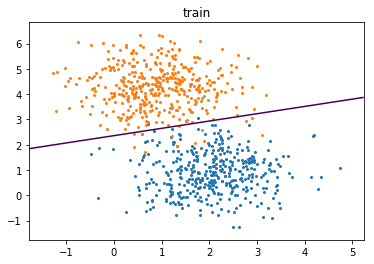

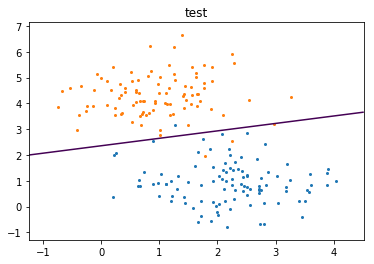

In [259]:
find_and_draw_perceptron(1, lambda x, y, w: w[0] + x * w[1] + y * w[2])

Train accuracy is 0.97625
Test accuracy is 0.985


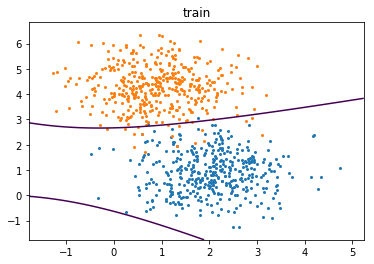

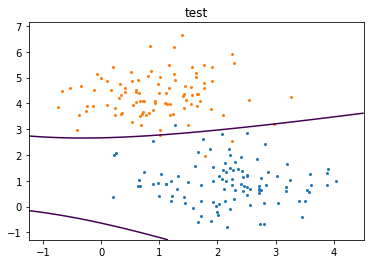

In [260]:
find_and_draw_perceptron(2, 
                         lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5])

Train accuracy is 0.97625
Test accuracy is 0.985


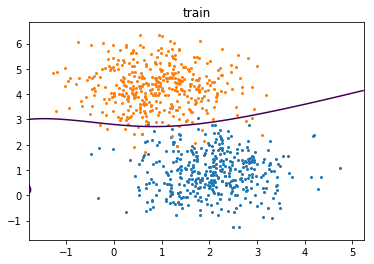

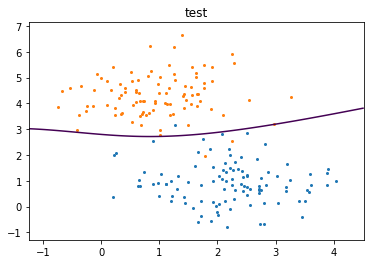

In [261]:
find_and_draw_perceptron(3, 
                         lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] +
                         x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9])

Train accuracy is 0.9825
Test accuracy is 0.985


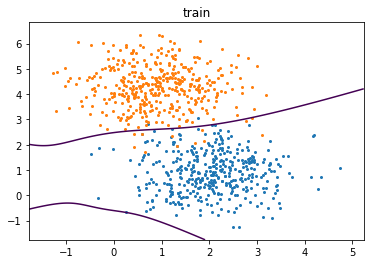

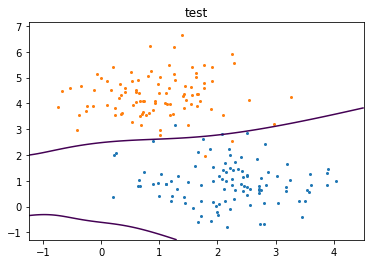

In [262]:
find_and_draw_perceptron(4, 
                         lambda x, y, w: w[0] + x * w[1] + y * w[2] +
                         x ** 2 * w[3] + x * y * w[4] + y ** 2 * w[5] +
                         x ** 3 * w[6] + x ** 2 * y * w[7] + x * y ** 2 * w[8] + y ** 3 * w[9] + 
                         x ** 4 * w[10] + x ** 3 * y * w[11] + (x * y) ** 2 * w[12] + x * y ** 3 * w[13] + y ** 4 * w[14])

**Logistic regression**

In [263]:
def logistic_regression(X, y, X_test, y_test, batch_size=30, epochs=50, learning_rate=0.05):
    X, X_test = PolynomialFeatures(1).fit_transform(X), PolynomialFeatures(1).fit_transform(X_test)
    w = np.random.rand(X.shape[1])
    batches = np.array_split(np.arange(X.shape[0]), X.shape[0] / batch_size)
    accuracies_test, accuracies_train = [], []
    for epoch in tqdm_notebook(range(epochs)):
        for batch in batches:
            grad = np.zeros_like(w)
            for i in batch:
                grad += y[i] * X[i] / (1 + np.exp(y[i] * np.dot(w, X[i])))
            w += grad / len(batch) * learning_rate
        accuracies_train.append(calc_accuracy(X, w, y)[0])
        accuracies_test.append(calc_accuracy(X_test, w, y_test)[0])
    return accuracies_train, accuracies_test

def draw_accuracy(accuracies_train, accuracies_test):
    plt.plot(range(len(accuracies_train)), accuracies_train, label='Train')
    plt.plot(range(len(accuracies_test)), accuracies_test, label='Test')
    plt.legend()
    plt.show()

def scale_data(data):
    return MinMaxScaler().fit_transform(data)            

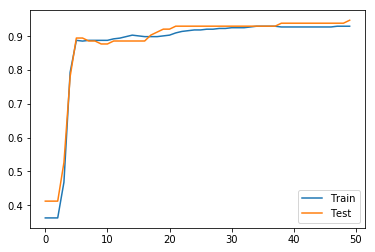

In [264]:
X_cancer, tmp_y_cancer = read_dataset('cancer.csv')
y_cancer = np.array([1 if l == 'M' else 0 for l in tmp_y_cancer])
X_cancer = scale_data(X_cancer)

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)
acc_train, acc_test = logistic_regression(X_train, modify_labels(y_train), X_test, modify_labels(y_test))
draw_accuracy(acc_train, acc_test)

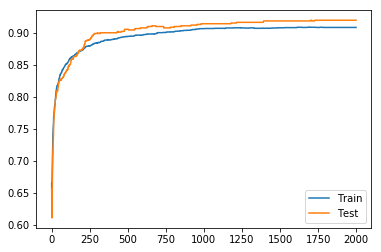

In [265]:
X_spam, y_spam = read_dataset('spam.csv')
X_spam = scale_data(X_spam)

X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, test_size=0.2)
acc_train, acc_test = logistic_regression(X_train, modify_labels(y_train), X_test, modify_labels(y_test), epochs=2000, batch_size=50, learning_rate=0.1)
draw_accuracy(acc_train, acc_test)

**Neural networks**

In [266]:
import torch
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

X_mnist, y_mnist = read_dataset('mnist.csv')
SIZE = 28
X_mnist = torch.tensor(X_mnist, dtype=torch.float).view(X_mnist.shape[0], 1, SIZE, SIZE)
y_mnist = torch.tensor(y_mnist, dtype=torch.long)


batch_size = 16
def split_dataset(X, y, val_size=0.2):
    dataset = TensorDataset(X, y)
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    split = int(val_size * dataset_size)
    
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    
    return train_loader, validation_loader

mnist_train_loader, mnist_validation_loader = split_dataset(X_mnist, y_mnist)

In [270]:
class MnistCNN(torch.nn.Module):
    
    def __init__(self, activations):
        super(MnistCNN, self).__init__()
        
        self.activations = activations
        
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = torch.nn.Linear(8 * SIZE * SIZE, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        
        self.out = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.activations[0](self.conv1(x))
        x = self.activations[1](self.conv2(x))
        x = self.activations[2](self.conv3(x))
        
        x = x.view(-1, 8 * SIZE * SIZE)
        
        x = self.activations[3](self.fc1(x))
        x = self.activations[4](self.fc2(x))
        
        x = torch.nn.functional.log_softmax(self.out(x), dim=1)
        return x
    
def predict(net, x):
        with torch.no_grad():
            y_pred = net(x)
        _, y_pred = torch.max(y_pred, 1)
        return y_pred

def get_accuracy(net, loader, batch_size):
    correct = 0
    for inputs, labels in loader:
        correct += (predict(net, inputs) == labels).sum().item()
    return correct / (len(loader) * batch_size) * 100

def trainNet(net, train_loader, validation_loader, batch_size, n_epochs, learning_rate, best_model_path):
    print("===== HYPERPARAMETERS =====")
    print("batch_size =", batch_size)
    print("epochs =", n_epochs)
    print("learning_rate =", learning_rate)
    print("=" * 30)
    
    loss = torch.nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    training_start_time = time.time()
    best_acc = 0
    
    for epoch in tqdm_notebook(range(n_epochs)):
        
        start_time = time.time()
        total_train_loss = 0
        
        for data in train_loader:
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            total_train_loss += loss_size.item()

        print(f"Epoch {epoch} \t train_loss: {total_train_loss / len(train_loader)}\t took: {time.time() - start_time}")
        start_time = time.time()
        
        total_val_loss = 0
        for inputs, labels in validation_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.item()
        
        accuracy = get_accuracy(net, validation_loader, batch_size)
        if best_acc < accuracy:
            best_acc = accuracy
            torch.save(net.state_dict(), best_model_path)
        
        print(f"Validation loss = {total_val_loss / len(validation_loader)}, current accuracy = {accuracy}%")
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [271]:
def train_mnist(f):
    path = 'best_model'
    print(f)
    net = MnistCNN(f)
    trainNet(net, mnist_train_loader, mnist_validation_loader, batch_size, 10, 0.001, path)
    net.load_state_dict(torch.load(path))
    net.eval()
    
    print(f'Accuracy is {get_accuracy(net, mnist_validation_loader, batch_size)}%')
    

In [272]:
train_mnist([torch.nn.ReLU()] * 5)

[ReLU(), ReLU(), ReLU(), ReLU(), ReLU()]
===== HYPERPARAMETERS =====
batch_size = 16
epochs = 10
learning_rate = 0.01


Epoch 0 	 train_loss: 0.31118099282681944	 took: 5.292393922805786
Validation loss = 0.1645086703300476, current accuracy = 95.35%
Epoch 1 	 train_loss: 0.08658255498111248	 took: 6.139232158660889
Validation loss = 0.15653211760520935, current accuracy = 95.89999999999999%
Epoch 2 	 train_loss: 0.04545988416671753	 took: 6.1839869022369385
Validation loss = 0.14328828275203706, current accuracy = 96.65%
Epoch 3 	 train_loss: 0.03912316842377186	 took: 6.176993131637573
Validation loss = 0.11267987942695618, current accuracy = 96.75%
Epoch 4 	 train_loss: 0.0339014475941658	 took: 6.202210903167725
Validation loss = 0.16461666631698607, current accuracy = 95.89999999999999%
Epoch 5 	 train_loss: 0.031024047315120696	 took: 6.221266984939575
Validation loss = 0.21332268059253692, current accuracy = 95.19999999999999%
Epoch 6 	 train_loss: 0.017387925505638124	 took: 6.2480788230896
Validation loss = 0.15377126204967498, current accuracy = 97.0%
Epoch 7 	 train_loss: 0.02792234459519386	

In [273]:
train_mnist([torch.nn.Tanh()] * 5)

[Tanh(), Tanh(), Tanh(), Tanh(), Tanh()]
===== HYPERPARAMETERS =====
batch_size = 16
epochs = 10
learning_rate = 0.01


Epoch 0 	 train_loss: 0.4147994123697281	 took: 5.351010799407959
Validation loss = 0.2026658775806427, current accuracy = 94.25%
Epoch 1 	 train_loss: 0.13300044099986552	 took: 5.369632005691528
Validation loss = 0.17425263106822966, current accuracy = 94.45%
Epoch 2 	 train_loss: 0.09498235723376273	 took: 5.359560012817383
Validation loss = 0.19637439811229707, current accuracy = 94.05%
Epoch 3 	 train_loss: 0.06691437911987305	 took: 5.751399993896484
Validation loss = 0.11254867863655091, current accuracy = 96.5%
Epoch 4 	 train_loss: 0.04626225566864014	 took: 5.479614019393921
Validation loss = 0.19066566562652587, current accuracy = 94.1%
Epoch 5 	 train_loss: 0.0492222860455513	 took: 5.784268140792847
Validation loss = 0.16149945843219757, current accuracy = 94.85%
Epoch 6 	 train_loss: 0.054408022046089174	 took: 5.802325963973999
Validation loss = 0.148222412109375, current accuracy = 95.5%
Epoch 7 	 train_loss: 0.045115118473768236	 took: 5.601834058761597
Validation loss

In [274]:
sigmoid = torch.nn.Sigmoid()
identity = lambda x: x
train_mnist([identity, identity, identity, sigmoid, sigmoid])

[<function <lambda> at 0x1a417368c8>, <function <lambda> at 0x1a417368c8>, <function <lambda> at 0x1a417368c8>, Sigmoid(), Sigmoid()]
===== HYPERPARAMETERS =====
batch_size = 16
epochs = 10
learning_rate = 0.01


Epoch 0 	 train_loss: 1.4567561128139497	 took: 6.883373975753784
Validation loss = 0.9816833176612854, current accuracy = 73.6%
Epoch 1 	 train_loss: 0.826453339099884	 took: 8.709678888320923
Validation loss = 0.7936140284538269, current accuracy = 76.6%
Epoch 2 	 train_loss: 0.7111977753639221	 took: 8.341846942901611
Validation loss = 0.7660831201076508, current accuracy = 76.14999999999999%
Epoch 3 	 train_loss: 0.7127581090331078	 took: 7.981284856796265
Validation loss = 0.6812309694290161, current accuracy = 77.8%
Epoch 4 	 train_loss: 0.6814736504852772	 took: 8.04284119606018
Validation loss = 1.4204856462478637, current accuracy = 55.60000000000001%
Epoch 5 	 train_loss: 0.7197715892791748	 took: 7.230811834335327
Validation loss = 0.6469978965520858, current accuracy = 79.3%
Epoch 6 	 train_loss: 0.6064371963739396	 took: 7.13309907913208
Validation loss = 0.6931270892620087, current accuracy = 78.35%
Epoch 7 	 train_loss: 0.5823129305839538	 took: 7.703492164611816
Validat

In [276]:
import os
from shutil import copyfile, rmtree

# Some code to create train and test dirs
train_dir = 'notMnist_train'
test_dir = 'notMnist_test'
from_dir = 'notMNIST_small/'
rmtree(train_dir)
rmtree(test_dir)
for letter in 'ABCDEFGHIJ':
    os.makedirs(os.path.join(train_dir, letter))
    os.makedirs(os.path.join(test_dir, letter))
    for file in os.listdir(os.path.join(from_dir, letter)):
        if np.random.uniform() > 0.2:
            copyfile(os.path.join(os.path.join(from_dir, letter, file)), os.path.join(train_dir, letter, file))
        else:
            copyfile(os.path.join(os.path.join(from_dir, letter, file)), os.path.join(test_dir, letter, file))

In [277]:
batch_size = 32
def load_notMNIST_dataset(path, transforms):
    dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform=torchvision.transforms.ToTensor()
    )
    if transforms:
        transformed_dataset = torchvision.datasets.ImageFolder(
            root=path,
            transform=transforms
        )
        dataset = torch.utils.data.ConcatDataset([dataset, transformed_dataset])
        
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


notmnist_train_loader = load_notMNIST_dataset(train_dir,
    torchvision.transforms.Compose([
        torchvision.transforms.RandomAffine(3, translate=(0.1, 0.1)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()]))
notmnist_validation_loader = load_notMNIST_dataset(test_dir, None)


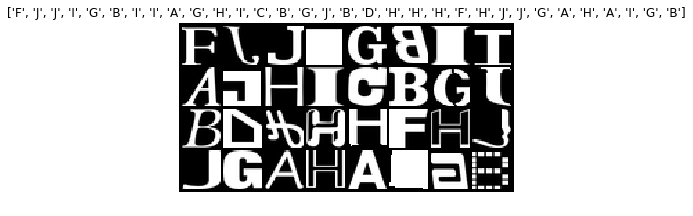

In [278]:
for x, labels in notmnist_train_loader:
    grid = torchvision.utils.make_grid(x)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(list(map(chr, labels.numpy() + ord('A'))));
    break

In [281]:
class NotMnistCNN(torch.nn.Module):
    
    def __init__(self):
        super(NotMnistCNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.drop_out = torch.nn.Dropout()
        self.drop_conv1 = torch.nn.Dropout(0.25)
        self.drop_conv2 = torch.nn.Dropout(0.25)
        
        self.fc1 = torch.nn.Linear(64 * (SIZE // 4) ** 2, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        
        self.out = torch.nn.Linear(64, 10)
        
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.relu3 = torch.nn.ReLU()
        self.relu4 = torch.nn.ReLU()
        self.relu5 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.drop_conv1(x)
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.drop_conv2(x)
        x = self.pool2(x)
        x = self.relu3(self.conv3(x))
        
        x = x.view(-1, 64 * (SIZE // 4) ** 2)
        x = self.drop_out(x)
        
        x = self.relu4(self.fc1(x))
        x = self.relu5(self.fc2(x))
        
        x = torch.nn.functional.log_softmax(self.out(x), dim=1)
        return x

def train_not_mnist():
    path = 'best_model'
    net = NotMnistCNN()
    trainNet(net, notmnist_train_loader, notmnist_validation_loader, batch_size, 20, 0.001, path)
    net.load_state_dict(torch.load(path))
    net.eval()

    print(f'Accuracy on train is {get_accuracy(net, notmnist_train_loader, batch_size)}%')
    print(f'Accuracy on validation is {get_accuracy(net, notmnist_validation_loader, batch_size)}%')
    return net

In [282]:
trained = train_not_mnist()

===== HYPERPARAMETERS =====
batch_size = 32
epochs = 20
learning_rate = 0.01


Epoch 0 	 train_loss: 0.6244817491426382	 took: 42.05757117271423
Validation loss = 0.2860983159906905, current accuracy = 91.8103448275862%
Epoch 1 	 train_loss: 0.3538384157628678	 took: 39.631550788879395
Validation loss = 0.2460183048106987, current accuracy = 93.10344827586206%
Epoch 2 	 train_loss: 0.29888848122506856	 took: 44.4058358669281
Validation loss = 0.2340724502272647, current accuracy = 93.15732758620689%
Epoch 3 	 train_loss: 0.26712335600528603	 took: 45.536080837249756
Validation loss = 0.24200109848431473, current accuracy = 92.5646551724138%
Epoch 4 	 train_loss: 0.25108967656398606	 took: 44.866055965423584
Validation loss = 0.20238475919026752, current accuracy = 93.72306034482759%
Epoch 5 	 train_loss: 0.2337597170259498	 took: 43.05442500114441
Validation loss = 0.19617371791010274, current accuracy = 94.20797413793103%
Epoch 6 	 train_loss: 0.2201398086830323	 took: 42.037617206573486
Validation loss = 0.21126499479829236, current accuracy = 93.29202586206897